<a href="https://colab.research.google.com/github/aleksandr-del/machine-learning-algorithms-from-scratch/blob/main/linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия с помощью градиентного спуска

Импортируем необходимые библиотеки, модули, функции:

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")

## Датасет

Из библиотеки `sklearn` скачаем данные о домах в Бостоне. В данных 506 наблюдений, 13 признаков и целевая переменная. Необходимо спрогнозировать стоимость дома:

In [7]:
data = load_boston()

Признаки упакуем в датафрейм и сохраним в переменной `X`:

In [10]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Целевую переменную сохраним в `y`:

In [13]:
y = data['target']
y[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

Разделим данные на обучающую и тестовую выборки:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Нормализуем значения признаков:

In [15]:
scaler = StandardScaler()

In [17]:
X_train = scaler.fit_transform(X_train)

In [18]:
X_test = scaler.transform(X_test)

## Градиентный спуск

Смысл градиентного спуска в поиске минимума функции в точке, в которой производная этой функции будет равна нулю (аналитически, найдя корень производной функции) или очень близка к нулю (численно).

Знак производной функции в точке показывает, возрастает функция в этой точке или убывает (ну или имеет экстремум, если производная функции равна нулю или не определена). 

Если производная в точке $x$ на нашем графике будет $> 0$, функция в этой точке возрастает, а это значит, что минимум функции находится левее точки $x$. Получается, если мы уменьшим $x$ на некоторую величину, то мы можем приблизиться к точке минимума.

Тогда поиск точки минимума сводится к следующему:

1. берем случайную точку $x$ функции $F$;
2. вычисляем производную $F'(x)$
3. если $F'(x) > 0$, уменьшаем $x$ ( функция возрастает); если $F'(x) < 0$ (функция убывает), увеличиваем $x$;
4. повторяем шаги 2-3, пока не приблизимся к минимуму функции. 

Уменьшать или увеличивать $x$ будем очень маленькими шагами, чтобы не перескочить точку минимума.

Для линейной регрессии мы будем оптимизировать, то есть искать минимум, функцию потерь  `mean squared error`:

$$MSE  = \frac{1}{n}\sum_{i=1}^{n}\left(y_{pred} - y_{true}\right)^2$$

А производная этой функции потерь выглядит так:

$$\frac{\partial{MSE}}{\partial{w}} = \frac{2}{n}(y_{pred} - Y) X $$

Будем искать такое значение $w$, при котором $MSE$ будет равна или очень близка к нулю.


### Шаг 1

#### Берем случайную величину $w$

Инициализируем случайные веса признаков. Весов у нас будет на 1 больше, чем признаков, так как нам нужен еще и свободный член в уравнении линейной регрессии:

In [75]:
w = np.random.randn(X.shape[1] + 1)
w

array([-0.28128993,  0.48226699,  0.66916029,  2.11942799, -0.94491985,
       -2.84444412,  1.06350122,  1.66383934,  0.67354859,  0.12335694,
       -0.94153276, -1.26368643,  0.56885558,  1.54543897])

### Шаг 2

#### Вычисляем производную функции потерь

Найдем градиент, то есть вектор частных производных нашей функции потерь:

In [76]:
gradient = 2 * ((np.hstack([np.ones([X.shape[0], 1]), X]) @ w) - y).reshape(-1, 1) * np.hstack([np.ones([X.shape[0], 1]), X])
gradient = np.mean(gradient, axis=0)
gradient

array([-1.04463047e+02, -1.77453594e+03,  3.76603103e+02, -2.33662571e+03,
       -2.14335149e+00, -7.59337815e+01, -6.16261816e+02, -9.26491531e+03,
       -1.54397611e+02, -3.29404387e+03, -9.01055144e+04, -2.20231803e+03,
       -1.92723231e+04, -2.13316130e+03])

### Шаг 3

### Обновляем веса $w$

Если $F'(x) > 0$, уменьшаем $w$. Если $F'(x) < 0$, увеличиваем $w$. Не забываем о скорости обучения:

In [77]:
w -= gradient * 0.01
w

array([ 7.63340541e-01,  1.82276264e+01, -3.09687074e+00,  2.54856851e+01,
       -9.23486338e-01, -2.08510630e+00,  7.22611937e+00,  9.43129925e+01,
        2.21752470e+00,  3.30637957e+01,  9.00113611e+02,  2.07594939e+01,
        1.93292087e+02,  2.28770520e+01])

## Класс линейной регрессии

Повторяем шаги 2, 3 до тех пор, пока не добьемся приемлемого качества или определенное количество итераций. Создадим для этого новый класс.

Реализуем класс линейной регрессии с помощью градиентного спуска:

In [68]:
class MyLinearRegression():
    def __init__(self, lr=0.1, iters=1000):
        self.lr = lr # скорость обучения
        self.iters = iters # количество итераций
        self.weights_ = None # веса признаков
        self.intercept_ = None # свободный член
        self.MSE_ = None # будем хранить значения MSE каждой итерации

    def fit(self, X, y): # на вход принимает таблицу с признаками и целевую переменную
        X = np.hstack([np.ones([X.shape[0], 1]), X]) # к таблице (массиву) признаков добавляем столбец для свободного члена
        y = y
        w = np.random.randn(X.shape[1]) # инициализируем случайне веса
        MSE = []

        for i in range(self.iters): # запускаем цикл
            error = np.mean((X @ w - y) ** 2) # считаем MSE
            MSE.append(error) # сохраняем среднеквадратическую ошибку в списке
            gradient = 2 * X.T @ (X @ w - y) / X.shape[0] # считаем градиент
            # в шаге 2 мы делали это двумя строками кода, можно и одной, если матрицу признаков транспонирвать и переставить множители местами 
            w -= gradient * self.lr / ((i + 1) ** 0.5) # обновляем веса
            # с каждой последующей итерацией скорость обучения будет снижаться
            
        self.weights_ = w[1:] # веса признаков
        self.intercept_ = w[0] # свободный член
        self.MSE_ = MSE # все MSE всех итераций

    def predict(self, X):
        X = X
        prediction = X @ self.weights_ + self.intercept_ # предсказываем
    
        return prediction   


Иницилизируем объект класса `MyLinearRegression`:

In [69]:
mlr = MyLinearRegression()

Обучим модель линейной регрессии:

In [70]:
mlr.fit(X_train, y_train)

Визуализуем, как улучшались метрика качества MSE с каждой последующей итерацией на обучающей выборке:

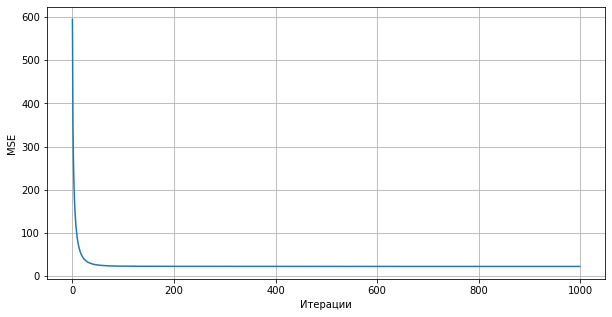

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(mlr.MSE_)
plt.grid(True)
plt.ylabel('MSE')
plt.xlabel('Итерации')
plt.show()

Посмотрим на величины весов признаков. Чем больше по модулю вес признака, тем он важнее:

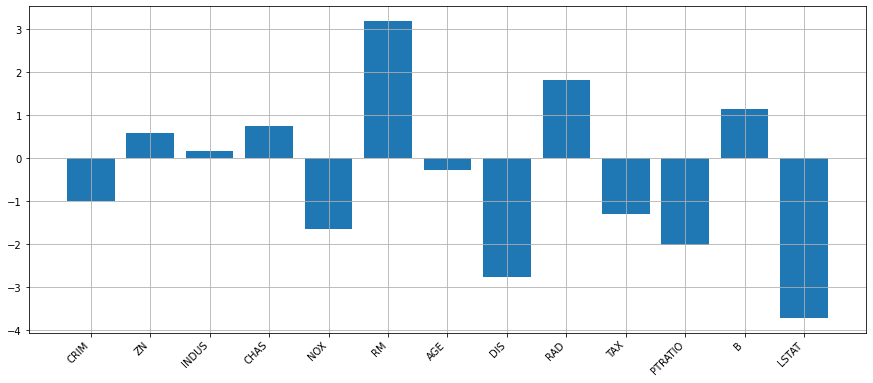

In [72]:
plt.figure(figsize=(15, 6))
plt.bar(data['feature_names'], mlr.weights_)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Проверим метрики качества модели на тестовой выборке:

In [73]:
print(f"R2: {r2_score(y_test, mlr.predict(X_test))}")
print(f"MSE: {mean_squared_error(y_test, mlr.predict(X_test))}")

R2: 0.6801475316404914
MSE: 22.398354749989693


Сравним с алгоритмом линейной регрессией из библиотеки `sklearn`:

In [59]:
lr = LinearRegression()

In [60]:
lr.fit(X_train, y_train)

LinearRegression()

In [61]:
print(f"R2: {r2_score(y_test, lr.predict(X_test))}")
print(f"MSE: {mean_squared_error(y_test, lr.predict(X_test))}")

R2: 0.6844267283527132
MSE: 22.098694827097976
